In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTEN
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [2]:
data=pd.read_csv(r'C:/Users/HCJ/Desktop/2021_Summer/Finance_data/bank.csv',index_col=0)
print(data.shape)

(119535, 93)


In [3]:
for col_name in data.columns:
    data[col_name]=pd.Categorical(data[col_name])

In [4]:
train_data, test_data = train_test_split(data,test_size=0.2, random_state=100)
print(train_data.shape)
print(test_data.shape)

(95628, 93)
(23907, 93)


In [5]:
X_train = train_data.iloc[:,1:]
y_train = train_data['TARGET']
X_test = test_data.iloc[:,1:]
y_test = test_data['TARGET']

In [6]:
smoten = SMOTEN()
X_train_samp, y_train_samp = smoten.fit_resample(X_train,y_train)

In [7]:
def get_eval(y_test,pred=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    precision2=precision_score(y_test,pred,pos_label=0)
    recall2=recall_score(y_test,pred,pos_label=0)
    f1_2=f1_score(y_test,pred,pos_label=0)
    print("confusion matrix")
    print(confusion)
    print('accuracy : {0:.4f} , precision : {1:.4f} , recall : {2:.4f}, F1 score : {3:.4f} \n precision(0) : {4:.4f} , recall(0) : {5:.4f}, f1(0) : {6:.4f}'.format(accuracy,precision, recall,f1,precision2,recall2,f1_2))
    
def precision_recall_curve_plot(y_test, pred_proba_cl):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_cl)
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label = 'ROC')
    plt.plot([0,1],[0,1],'k--',label='Random')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1);plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)');plt.ylabel('TPR(Recall)')
    plt.legend()

In [8]:
## Split the data to be 5-fold cross-validated
kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)

In [9]:
#randomforest model - hyperparameter tuning using grid search
params = { 'n_estimators': [100, 150, 200],
            'max_depth' : [10, 20, 30],
            'min_samples_leaf' : [8, 12, 18],
            'min_samples_split' : [2, 5, 10]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=3, n_jobs = -1, verbose=2)
grid_cv.fit(X_train_samp, y_train_samp)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
최적 하이퍼 파라미터:  {'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 150}
최고 예측 정확도: 0.9971


In [21]:
# test 파라미터
rf_clf1 =RandomForestClassifier(max_depth = 10,
                                min_samples_leaf = 30,
                                min_samples_split = 20,
                                n_estimators = 100)

rf_clf1.fit(X_train_samp, y_train_samp)
pred = rf_clf1.predict(X_test)
get_eval(y_test,pred)

confusion matrix
[[22702  1049]
 [   65    91]]
accuracy : 0.9534 , precision : 0.0798 , recall : 0.5833, F1 score : 0.1404 
 precision(0) : 0.9971 , recall(0) : 0.9558, f1(0) : 0.9761


In [22]:
# best 파라미터
rf_clf2 =RandomForestClassifier(max_depth = 30,
                                min_samples_leaf = 8,
                                min_samples_split = 2,
                                n_estimators = 150)

rf_clf2.fit(X_train_samp, y_train_samp)
pred2 = rf_clf2.predict(X_test)
get_eval(y_test,pred2)

confusion matrix
[[23715    36]
 [  112    44]]
accuracy : 0.9938 , precision : 0.5500 , recall : 0.2821, F1 score : 0.3729 
 precision(0) : 0.9953 , recall(0) : 0.9985, f1(0) : 0.9969


In [23]:
# 샘플링 미적용
rf_clf3 =RandomForestClassifier(max_depth = 30,
                                min_samples_leaf = 8,
                                min_samples_split = 2,
                                n_estimators = 200)

rf_clf3.fit(X_train, y_train)
pred3 = rf_clf3.predict(X_test)
get_eval(y_test,pred3)

confusion matrix
[[23751     0]
 [  156     0]]
accuracy : 0.9935 , precision : 0.0000 , recall : 0.0000, F1 score : 0.0000 
 precision(0) : 0.9935 , recall(0) : 1.0000, f1(0) : 0.9967


C:\Users\HCJ\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
# 디폴트
rf_clf4 = RandomForestClassifier()

rf_clf4.fit(X_train_samp, y_train_samp)
pred4 = rf_clf4.predict(X_test)
get_eval(y_test,pred4)

confusion matrix
[[23743     8]
 [   77    79]]
accuracy : 0.9964 , precision : 0.9080 , recall : 0.5064, F1 score : 0.6502 
 precision(0) : 0.9968 , recall(0) : 0.9997, f1(0) : 0.9982


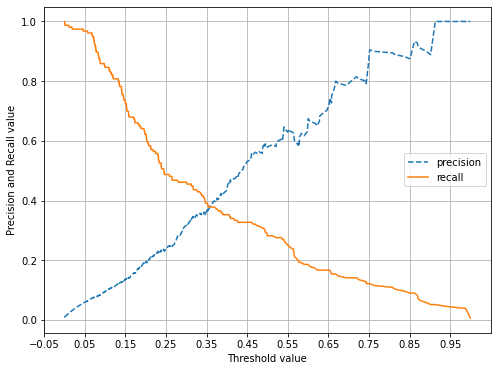

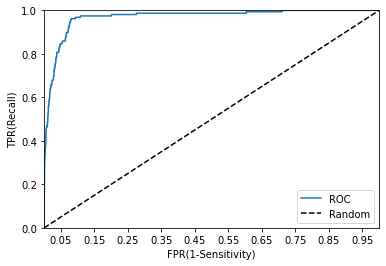

In [14]:
predict_prob_class=rf_clf2.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, predict_prob_class)
roc_curve_plot(y_test, predict_prob_class)

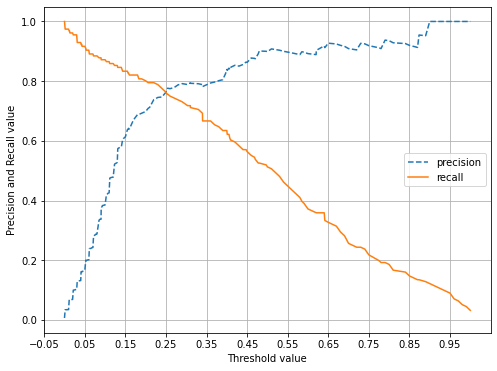

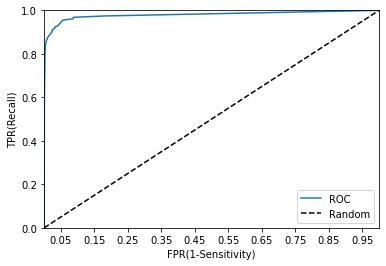

In [15]:
predict_prob_class2=rf_clf4.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, predict_prob_class2)
roc_curve_plot(y_test, predict_prob_class2)

Precision Recall Plot 
Precision Recall Plot (이하 PR 그래프)의 경우도 ROC 와 유사한데, 주로 데이타 라벨의 분포가 심하게 불균등 할때 사용한데, 예를 들어 이상 거래 검출 시나리오의 경우 정상 거래의 비율이 비정상 거래에 비해서 압도적으로 많기 때문에 (98%, 2%) 이런 경우에는 ROC 그래프보다 PR 그래프가 분석에 더 유리하다.
https://bcho.tistory.com/1206

Average precision-recall score: 0.37


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.37')

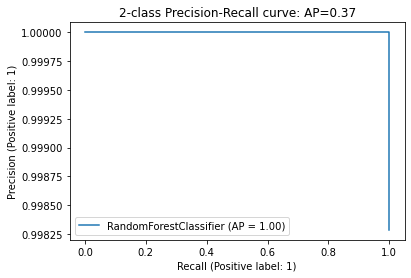

In [24]:
# Precision-Recall Curve best grid
y_score = rf_clf2.predict_proba(X_test)[:,1]

average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(rf_clf4, X_train_samp, y_train_samp)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Average precision-recall score: 0.77


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.77')

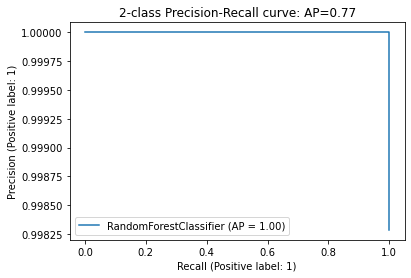

In [25]:
# Precision-Recall Curve default
y_score = rf_clf4.predict_proba(X_test)[:,1]

average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

disp = plot_precision_recall_curve(rf_clf4, X_train_samp, y_train_samp)

disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [19]:
# AUC grid
roc_auc_score(y_test, predict_prob_class)

0.9693693059077674

In [20]:
# AUC 디폴트
roc_auc_score(y_test, predict_prob_class2)

0.9797831724224298